In [1]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, cv, DMatrix

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
import numpy as np 
import pandas as pd 

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Predictive Maintenance of the Air Production Unit on a MetroPT3 locomotive 

From the creators of the Dataset:

The dataset was collected to support the development of predictive maintenance, anomaly detection, and remaining
useful life (RUL) prediction models for compressors using deep learning and machine learning methods.
It consists of multivariate time series data obtained from several analogue and digital sensors installed on the
compressor of a train. The data span between February and August 2020 and includes 15 signals, such as pressures,
motor current, oil temperature, and electrical signals of air intake valves. The monitoring and logging of industrial
equipment events, such as temporal behaviour and fault events, were obtained from records generated by the
sensors. The data were logged at 1Hz by an onboard embedded device. You can find a schematic diagram of the air
production unit of the compressor system in Figure 4 of the accompanying paper [1]. Also, the paper [2] provides a
detailed examination of data collection and specifications of various types of potential failures in an air compressor
system

Attribute Information:
The dataset consists of 1516948 data points collected at 1Hz  from February to August 2020 and is described by 15 features from 7 analogue (1-7) and 8 digital (8-15) sensors:
1. TP2 (bar) – the measure of the pressure on the compressor.
2. TP3 (bar) – the measure of the pressure generated at the pneumatic panel.
3. H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.
4. DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.
5. Reservoirs (bar) – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).
6. Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.
7. Oil Temperature (ºC) –  the measure of the oil temperature on the compressor.
8. COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.
9. DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.
10. TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.
11. MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.
12. LPS – the electrical signal that detects and activates when the pressure drops below 7 bars.
13. Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.
14. Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.
15. Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.

Relevant Papers:
[1]- Davari, N., Veloso, B., Ribeiro, R.P., Pereira, P.M., Gama, J.: Predictive maintenance based on anomaly
detection using deep learning for air production unit in the railway industry. In: 2021 IEEE 8th International
Conference on Data Science and Advanced Analytics (DSAA). pp. 1–10. IEEE (2021) (DOI:
10.1109/DSAA53316.2021.9564181)
 
[2] Veloso, B., Ribeiro, R.P., Pereira, P.M., Gama, J.: The MetroPT dataset for predictive maintenance. Scientific
Data 9, no. 1 (2022): 764. (DOI: 10.1038/s41597-022-01877-3)

[3]-Barros, M., Veloso, B., Pereira, P.M., Ribeiro, R.P., Gama, J.: Failure detection of an air production unit in the
operational context. In: IoT Streams for Data-Driven Predictive Maintenance and IoT, Edge, and Mobile for
Embedded Machine Learning, pp. 61–74. Springer (2020) (DOI: 10.1007/978-3-030-66770-2_5)

Source:
Narjes Davari, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, narjes.davari@inesctec.pt
Bruno Veloso, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Economics,
University of Porto, Portugal bveloso@fep.up.pt
Rita P. Ribeiro, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Sciences,
University of Porto, Portugal. rpribeiro@fc.up.pt
Joao Gama, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Economics,
University of Porto, Portugal. jgama@fep.up.pt

Failure Information:

The dataset is unlabeled, but the failure reports provided by the company are available in the following table. This allows for evaluating the effectiveness of anomaly detection, failure prediction, and RUL estimation algorithms.

  Nr.     Start Time	          End Time	                 Failure	      Severity	         Report
  
#1 	4/18/2020 0:00	   4/18/2020 23:59       Air leak	    High stress	

#2 	5/29/2020 23:30     5/30/2020 6:00	    Air Leak	    High stress	Maintenance on 30Apr at 12:00

#3 	6/5/2020 10:00	   6/7/2020 14:30	        Air Leak	    High stress	Maintenance on 8Jun at 16:00

#4 	7/15/2020 14:30     7/15/2020 19:00      Air Leak	    High stress	Maintenance on 16Jul at 00:00

In [2]:
# Reading in MetroPT3 Air Compressor data

n = 10  # e.g. every 100th line = 1% of the lines
#, skiprows=lambda i: i % n != 0
metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', header=0 , index_col ='timestamp')

#metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', nrows=800000)
metro_df_large.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,0,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:10,10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:19,20,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:29,30,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:39,40,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [3]:
metro_df_large.shape

(1516948, 16)

In [4]:
metro_df_large = metro_df_large.rename(columns={'DV_eletric':'DV_electric'})

# Exploratory Data Analysis

In [5]:
# Summary statistics of the numeric features
metro_df_large.describe()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06
mean,7.584735e+06,1.367826e+00,8.984611e+00,7.568155e+00,5.595619e-02,8.985233e+00,6.264418e+01,2.050171e+00,8.369568e-01,1.606106e-01,9.198483e-01,8.326640e-01,3.420025e-03,9.914368e-01,9.041556e-01,9.371066e-01
std,4.379053e+06,3.250930e+00,6.390951e-01,3.333200e+00,3.824015e-01,6.383070e-01,6.516261e+00,2.302053e+00,3.694052e-01,3.671716e-01,2.715280e-01,3.732757e-01,5.838091e-02,9.214078e-02,2.943779e-01,2.427712e-01
min,0.000000e+00,-3.200000e-02,7.300000e-01,-3.600000e-02,-3.200000e-02,7.120000e-01,1.540000e+01,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.792368e+06,-1.400000e-02,8.492000e+00,8.254000e+00,-2.200000e-02,8.494000e+00,5.777500e+01,4.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,7.584735e+06,-1.200000e-02,8.960000e+00,8.784000e+00,-2.000000e-02,8.960000e+00,6.270000e+01,4.500000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,1.137710e+07,-1.000000e-02,9.492000e+00,9.374000e+00,-1.800000e-02,9.492000e+00,6.725000e+01,3.807500e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,1.516947e+07,1.067600e+01,1.030200e+01,1.028800e+01,9.844000e+00,1.030000e+01,8.905000e+01,9.295000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
# Examining null count and data types of features
metro_df_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1516948 entries, 2020-02-01 00:00:00 to 2020-09-01 03:59:50
Data columns (total 16 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1516948 non-null  int64  
 1   TP2              1516948 non-null  float64
 2   TP3              1516948 non-null  float64
 3   H1               1516948 non-null  float64
 4   DV_pressure      1516948 non-null  float64
 5   Reservoirs       1516948 non-null  float64
 6   Oil_temperature  1516948 non-null  float64
 7   Motor_current    1516948 non-null  float64
 8   COMP             1516948 non-null  float64
 9   DV_electric      1516948 non-null  float64
 10  Towers           1516948 non-null  float64
 11  MPG              1516948 non-null  float64
 12  LPS              1516948 non-null  float64
 13  Pressure_switch  1516948 non-null  float64
 14  Oil_level        1516948 non-null  float64
 15  Caudal_impulses  1516948 non-null  float6

In [7]:
metro_df_large.index.dtype

dtype('O')

In [8]:
# Converting index to datetime datatype
metro_df_large.index = pd.to_datetime(metro_df_large.index) 

# Removing rows that occur during failed period to create a dataframe of metrics during normal operation
normal_op_df = metro_df_large.loc[((metro_df_large.index < '04-18-2020 00:00:00') | (metro_df_large.index >'04-18-2020 23:59:00')) & 
                  ((metro_df_large.index < '05-29-2020 23:30:00') | (metro_df_large.index >'05-30-2020 06:00:00')) &
                  ((metro_df_large.index < '06-05-2020 10:00:00') | (metro_df_large.index >'06-07-2020 14:30:00')) &
                  ((metro_df_large.index < '07-15-2020 14:30:00') | (metro_df_large.index >'07-15-2020 19:00:00'))]

In [9]:
normal_op_df.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,0,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:10,10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:19,20,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:29,30,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:39,40,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


# Creating a target feature

The valuable information of the actual machinery failures needs to be transformed into a feature in the dataframe. Here I take steps to create failure_start, failure_end, and failure_duration features. I will use these to test the performance of the classification model.

In [10]:
# Creating a dataframe of failure data from the provided failure table

dt_fail_starts = pd.to_datetime(['2020-04-18 00:00','2020-05-29 23:30','2020-06-05 10:00','2020-07-15 14:30'])
dt_fail_ends = pd.to_datetime(['04/18/2020 23:59', '05/30/2020 6:00', '06/07/2020 14:30', '07/15/2020 19:00'])

fail_ranges_week = [pd.date_range(start=(fail_start - pd.Timedelta(days=7)), end=fail_start) for fail_start in dt_fail_starts]
fail_ranges_day = [pd.date_range(start=(fail_start - pd.Timedelta(days=1)), end=fail_start) for fail_start in dt_fail_starts]
fail_ranges_hour = [pd.date_range(start=(fail_start - pd.Timedelta(hours=1)), end=fail_start) for fail_start in dt_fail_starts]

failure_df = pd.DataFrame(list(zip(fail_ranges_week, fail_ranges_day, fail_ranges_hour, dt_fail_starts, dt_fail_ends)), columns=['pre_fail_week','pre_fail_day','pre_fail_hour','failure_start','failure_end'])
failure_df.set_index('pre_fail_week')
failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,"DatetimeIndex(['2020-04-11', '2020-04-12', '20...","DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
1,"DatetimeIndex(['2020-05-22 23:30:00', '2020-05...","DatetimeIndex(['2020-05-28 23:30:00', '2020-05...","DatetimeIndex(['2020-05-29 22:30:00'], dtype='...",2020-05-29 23:30:00,2020-05-30 06:00:00
2,"DatetimeIndex(['2020-05-29 10:00:00', '2020-05...","DatetimeIndex(['2020-06-04 10:00:00', '2020-06...","DatetimeIndex(['2020-06-05 09:00:00'], dtype='...",2020-06-05 10:00:00,2020-06-07 14:30:00
3,"DatetimeIndex(['2020-07-08 14:30:00', '2020-07...","DatetimeIndex(['2020-07-14 14:30:00', '2020-07...","DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00


In [11]:
failure_df = failure_df.explode('pre_fail_week')

failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,2020-04-11 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-13 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-14 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-15 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-16 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-17 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-18 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
1,2020-05-22 23:30:00,"DatetimeIndex(['2020-05-28 23:30:00', '2020-05...","DatetimeIndex(['2020-05-29 22:30:00'], dtype='...",2020-05-29 23:30:00,2020-05-30 06:00:00
1,2020-05-23 23:30:00,"DatetimeIndex(['2020-05-28 23:30:00', '2020-05...","DatetimeIndex(['2020-05-29 22:30:00'], dtype='...",2020-05-29 23:30:00,2020-05-30 06:00:00


In [12]:
failure_df = failure_df.explode('pre_fail_day')
failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,2020-04-11 00:00:00,2020-04-17 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-11 00:00:00,2020-04-18 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-17 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-18 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-13 00:00:00,2020-04-17 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
...,...,...,...,...,...
3,2020-07-13 14:30:00,2020-07-15 14:30:00,"DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-14 14:30:00,"DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-15 14:30:00,"DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-15 14:30:00,2020-07-14 14:30:00,"DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00


In [13]:
#failure_df.pre_fail_day.value_counts()

In [14]:
failure_df = failure_df.explode('pre_fail_hour')
failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,2020-04-11 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-11 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-13 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
...,...,...,...,...,...
3,2020-07-13 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-15 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00


In [15]:
failure_df.pre_fail_hour.value_counts()

2020-04-17 23:00:00    16
2020-05-29 22:30:00    16
2020-06-05 09:00:00    16
2020-07-15 13:30:00    16
Name: pre_fail_hour, dtype: int64

In [16]:
# Creating a fail_duration feature by subtracting datetime objects, returning a timedelta

failure_df['fail_duration'] = failure_df['failure_end'] - failure_df['failure_start'] 
failure_df['fail_date'] = failure_df['failure_start'].dt.date
failure_df = failure_df.set_index('pre_fail_week').sort_index()


print(failure_df.dtypes)
failure_df

pre_fail_day      datetime64[ns]
pre_fail_hour     datetime64[ns]
failure_start     datetime64[ns]
failure_end       datetime64[ns]
fail_duration    timedelta64[ns]
fail_date                 object
dtype: object


,pre_fail_day,pre_fail_hour,failure_start,failure_end,fail_duration,fail_date
pre_fail_week,,,,,,
2020-04-11 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00,0 days 23:59:00,2020-04-18
2020-04-11 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00,0 days 23:59:00,2020-04-18
2020-04-12 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00,0 days 23:59:00,2020-04-18
2020-04-12 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00,0 days 23:59:00,2020-04-18
2020-04-13 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00,0 days 23:59:00,2020-04-18
...,...,...,...,...,...,...
2020-07-13 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00,0 days 04:30:00,2020-07-15
2020-07-14 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00,0 days 04:30:00,2020-07-15
2020-07-14 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00,0 days 04:30:00,2020-07-15


In [17]:
failure_df.fail_duration.value_counts()

0 days 23:59:00    16
0 days 06:30:00    16
2 days 04:30:00    16
0 days 04:30:00    16
Name: fail_duration, dtype: int64

In [18]:
metro_df_large.index = pd.to_datetime(metro_df_large.index)

In [19]:
tol = pd.Timedelta(metro_df_large.index[1] - metro_df_large.index[0])
#tol = pd.Timedelta('10 minutes')

merged_df = pd.merge_asof(left = metro_df_large,right = failure_df, left_index= True, right_index=True, direction='nearest', tolerance=tol).drop(columns='Unnamed: 0', axis=1)
merged_df

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,...,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_day,pre_fail_hour,failure_start,failure_end,fail_duration,fail_date
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01 03:59:10,-0.014,8.918,8.906,-0.022,8.918,59.675,0.0425,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-09-01 03:59:20,-0.014,8.904,8.888,-0.020,8.904,59.600,0.0450,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-09-01 03:59:30,-0.014,8.890,8.876,-0.022,8.892,59.600,0.0425,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN


In [20]:
merged_df.pre_fail_hour.value_counts()

2020-06-05 09:00:00    16
2020-04-17 23:00:00    12
2020-07-15 13:30:00    11
2020-05-29 22:30:00     9
Name: pre_fail_hour, dtype: int64

In [21]:
hour_pre_fail_df = merged_df.loc[merged_df['pre_fail_hour'].notnull()]

hour_pre_fail_df.describe()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,fail_duration
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.0,48.000000,48.000000,48.000000,48
mean,2.776625,8.815458,5.894917,0.150792,8.816417,65.442188,2.539792,0.625000,0.354167,0.833333,0.625000,0.0,0.979167,0.979167,0.979167,1 days 01:44:45
std,4.163514,0.599640,4.252094,0.576196,0.598975,7.133132,2.613918,0.489246,0.483321,0.376622,0.489246,0.0,0.144338,0.144338,0.144338,0 days 20:31:09.001992169
min,-0.018000,8.054000,-0.028000,-0.024000,8.056000,49.450000,0.037500,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0 days 04:30:00
25%,-0.014000,8.306500,-0.008500,-0.020500,8.308000,60.437500,0.040000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,1.000000,1.000000,0 days 06:30:00
50%,-0.010000,8.575000,8.277000,-0.018000,8.577000,65.700000,1.863750,1.000000,0.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0 days 23:59:00
75%,8.295500,9.358000,9.080500,-0.016000,9.354500,67.850000,5.586875,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,2 days 04:30:00
max,9.994000,9.948000,9.940000,2.330000,9.950000,81.875000,5.970000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,2 days 04:30:00


In [22]:
failure_dates = ['2020-04-18','2020-05-29','2020-06-05','2020-07-15']
failure_dts = pd.to_datetime(['2020-04-18 00:00','2020-05-29 23:30','2020-06-05 10:00','2020-07-15 14:30'])
dates_regex = '|'.join(failure_dates)
failure_dts

DatetimeIndex(['2020-04-18 00:00:00', '2020-05-29 23:30:00',
               '2020-06-05 10:00:00', '2020-07-15 14:30:00'],
              dtype='datetime64[ns]', freq=None)

In [23]:
# Creating a pre_fail_week feature by comparing timestamps with a date range ending at start of failures and starting 7 days prior
metro_df_large['pre_fail_week'] = metro_df_large.index.round('D').isin(failure_df.index)

metro_df_large['pre_fail_day'] = metro_df_large.index.round('D').isin(failure_df.pre_fail_day)

metro_df_large['pre_fail_hour'] = metro_df_large.index.round('H').isin(failure_df.pre_fail_hour)

In [24]:
metro_df_large.describe()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06
mean,7.584735e+06,1.367826e+00,8.984611e+00,7.568155e+00,5.595619e-02,8.985233e+00,6.264418e+01,2.050171e+00,8.369568e-01,1.606106e-01,9.198483e-01,8.326640e-01,3.420025e-03,9.914368e-01,9.041556e-01,9.371066e-01
std,4.379053e+06,3.250930e+00,6.390951e-01,3.333200e+00,3.824015e-01,6.383070e-01,6.516261e+00,2.302053e+00,3.694052e-01,3.671716e-01,2.715280e-01,3.732757e-01,5.838091e-02,9.214078e-02,2.943779e-01,2.427712e-01
min,0.000000e+00,-3.200000e-02,7.300000e-01,-3.600000e-02,-3.200000e-02,7.120000e-01,1.540000e+01,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.792368e+06,-1.400000e-02,8.492000e+00,8.254000e+00,-2.200000e-02,8.494000e+00,5.777500e+01,4.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,7.584735e+06,-1.200000e-02,8.960000e+00,8.784000e+00,-2.000000e-02,8.960000e+00,6.270000e+01,4.500000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,1.137710e+07,-1.000000e-02,9.492000e+00,9.374000e+00,-1.800000e-02,9.492000e+00,6.725000e+01,3.807500e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,1.516947e+07,1.067600e+01,1.030200e+01,1.028800e+01,9.844000e+00,1.030000e+01,8.905000e+01,9.295000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [25]:
metro_df_large['pre_fail_day'].value_counts()

False    1501984
True       14964
Name: pre_fail_day, dtype: int64

The following boxplot examines the oil temperature during normal operation to that of the 24 hours leading up to failure. During the pre failure period, the temperature has a lower median, yet both higher highs and lower lows, indicating a higher variance in Oil Temperature during the the pre failure period.

<Axes: xlabel='pre_fail_day', ylabel='Oil_temperature'>

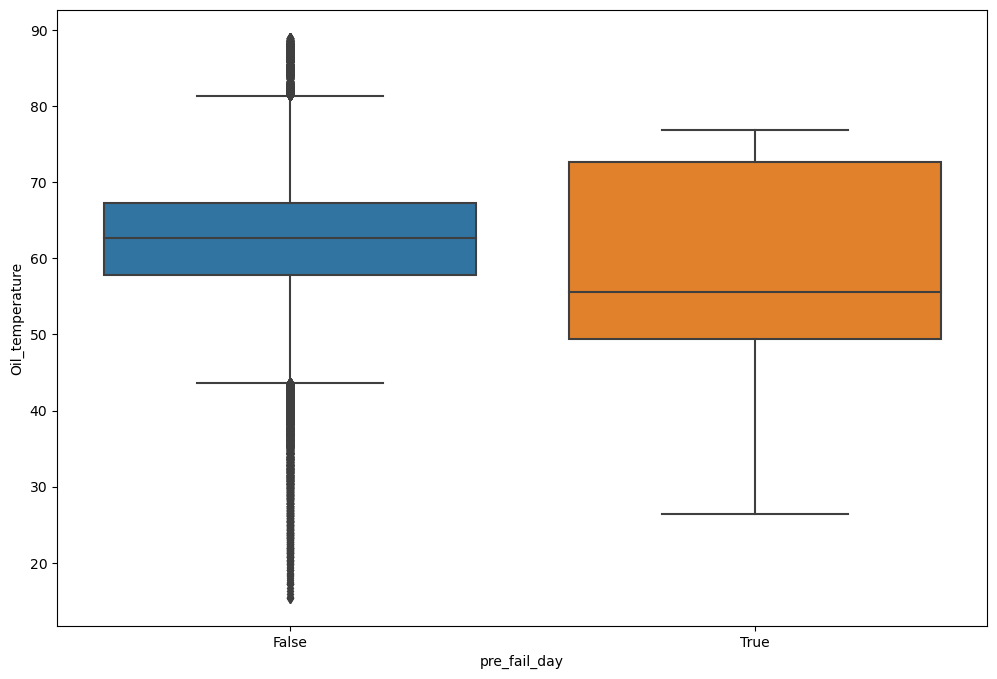

In [26]:
plt.figure(figsize=(12, 8))
sns.boxplot(data= metro_df_large, x='pre_fail_day', y='Oil_temperature')

In [27]:
#metro_df_large['pre_fail_week'].value_counts() 

In [28]:
metro_df_large.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour
timestamp,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,0,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False
2020-02-01 00:00:10,10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False
2020-02-01 00:00:19,20,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False
2020-02-01 00:00:29,30,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False
2020-02-01 00:00:39,40,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False


In [29]:
print(metro_df_large.pre_fail_hour.value_counts())
print(metro_df_large.pre_fail_day.value_counts())

False    1516287
True         661
Name: pre_fail_hour, dtype: int64
False    1501984
True       14964
Name: pre_fail_day, dtype: int64


Examining the relationship between oil temperature, oil level and the dv_electric state, separated into normal operation and the 24 hours pre-failure. The oil level variable is True when the oil level is below the expected level. The DV_electric variable is 1.0/True when the compressor is operating under load and 0/False when compressor is off or operating in an offloaded state.

**As shown, when the compressor is within the 24 hours leading up to a failure**:

    1. The oil level variable is almost exclusively True, indicating a lower than expected oil level.

    2. Oil temperature during offloaded state with low oil level is similar to normal operation temperatures, apart from the large aggregation at the relatively low ~50 degrees Celsius.

    3. Oil temperature during a loaded state with lower than expected oil levels reveals a heavily aggregated cluster at ~72-78 degrees Celsius. Under normal operation but with low oil levels, the oil temperature reaches these temperatures, but also includes many values near ~70 degrees C and near 65 degrees C. This could indicate that during the 24 hours pre failure, oil temperatures rise quickly to a high but acceptable maximum temperature while operating under load and having a lower than expected oil level.
    
These conclusions could point to drastic changes in oil temperature leading to failures. Many materials can be developed to withstand temperature extremes, but drastic changes in temperature can lead to differing rates of expansion/contraction within the system, or within the same component.

<Figure size 1200x800 with 0 Axes>

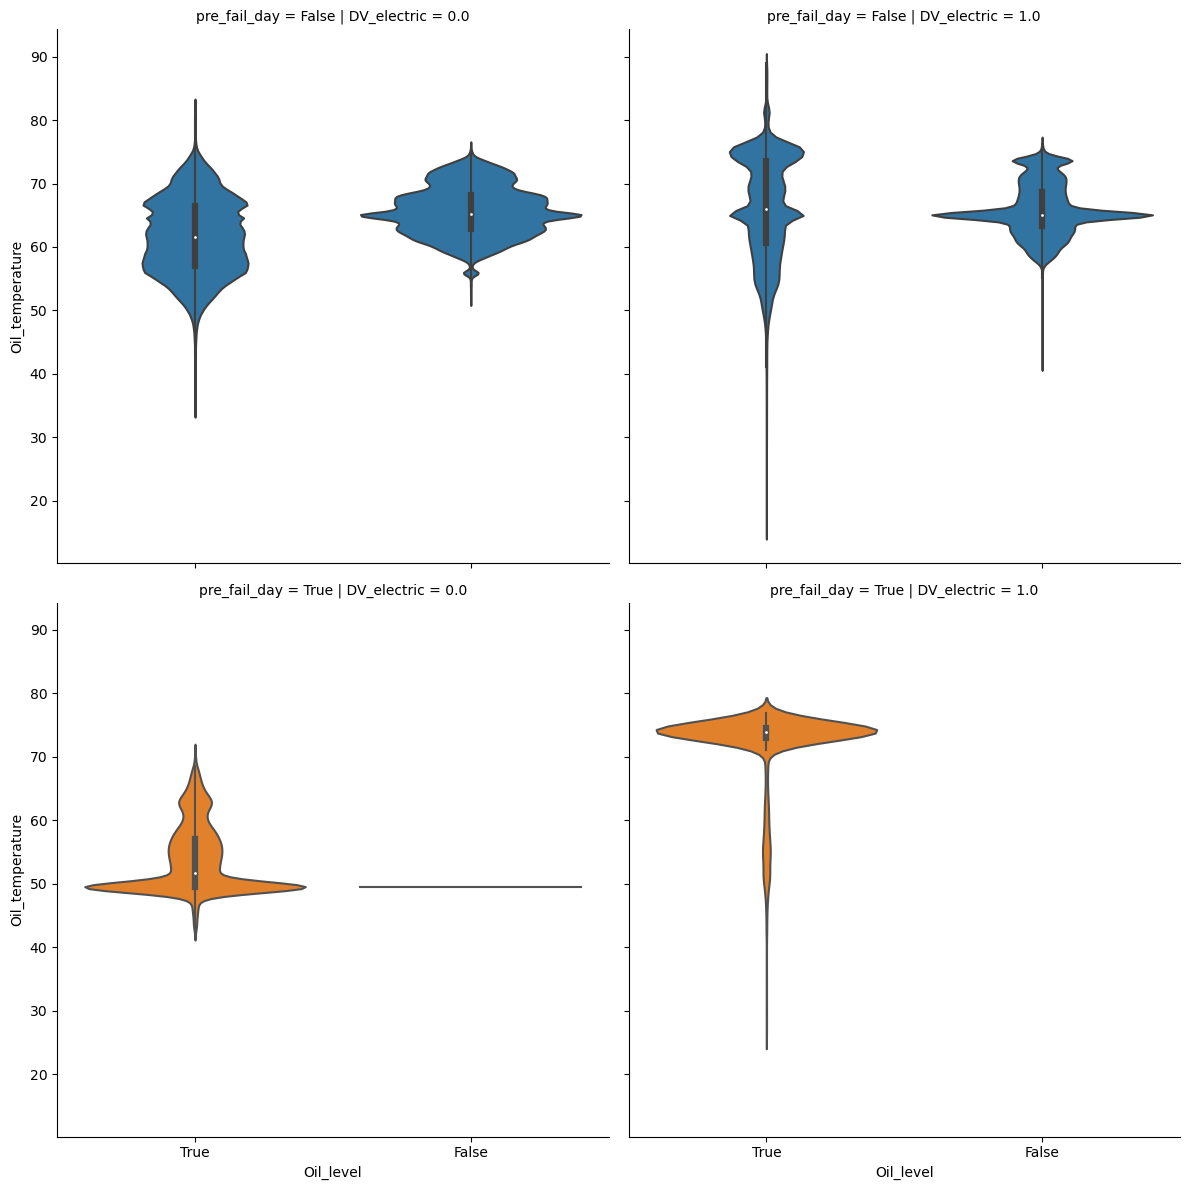

In [30]:
plt.figure(figsize=(12, 8))
grid = sns.FacetGrid(metro_df_large, row='pre_fail_day', col='DV_electric', hue='pre_fail_day', height=6)
grid.map(sns.violinplot, 'Oil_level', 'Oil_temperature', order=[True, False])

In [31]:
#week_pre_fail_df = metro_df_large.loc[metro_df_large['pre_fail_week'] == 1]
#week_pre_fail_df

In [32]:
# Creating a dataframe to compare aggregate values between period leading up to a failure and period of normal operation
# ADJUST to use only pre failure period data for 'normal operation'
# RECTIFY data to consider active state of influential components. Mostly simple On/Off categories directly affecting continuous vars

data = {'near_failure_oil_temp': hour_pre_fail_df['Oil_temperature'], 'normal_oil_temp': normal_op_df['Oil_temperature']}
oil_temp_diff = pd.DataFrame(data=data)
oil_temp_diff.describe()

,near_failure_oil_temp,normal_oil_temp
count,48.000000,1.486994e+06
mean,65.442188,6.238323e+01
std,7.133132,6.300423e+00
min,49.450000,1.540000e+01
25%,60.437500,5.767500e+01
50%,65.700000,6.255000e+01
75%,67.850000,6.697500e+01
max,81.875000,8.312500e+01


The median oil temperature during the hour leading up to a failure is slightly higher, and includes no low temperature outliers, which which would indicate a compressor operating in a non-loaded/ less-stressed state.The oil temperature while under normal operation indicates a lower median and has many low temperature outliers.

Text(0.5, 1.0, 'One Hour Pre-Failure vs Normal Operation: Oil Temperature')

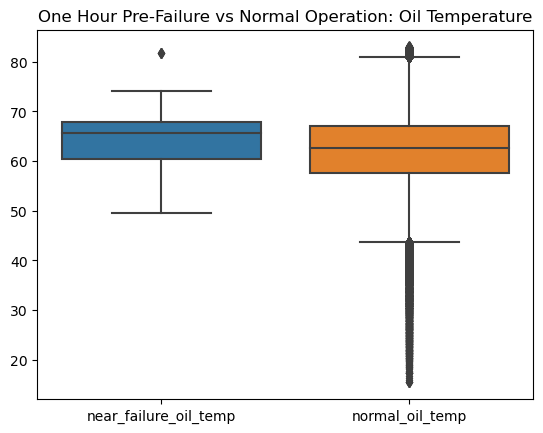

In [33]:
sns.boxplot(data=oil_temp_diff).set_title('One Hour Pre-Failure vs Normal Operation: Oil Temperature')

Next, I create a comparison of the DV_pressure between normal operation data and one hour pre failure data. When this value is zero, it indicates the compressor is operating under load. As shown in the plot, the data from an hour before failure is operating under load much more frequently. As this is expected and intuitive, further plots will examine the details of the compressor Operating Under Load.

Text(0.5, 1.0, 'One Hour Pre-Failure vs Normal Operation: DV Pressure')

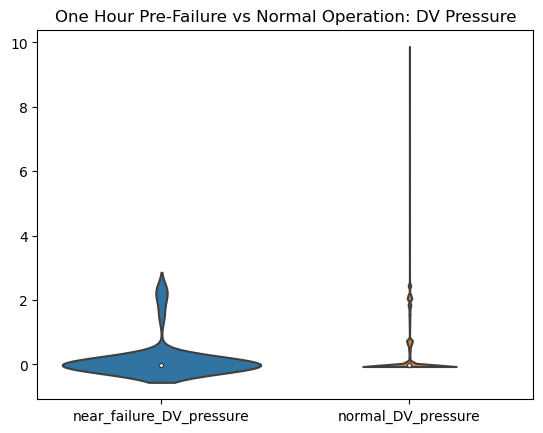

In [34]:
dv_data = {'near_failure_DV_pressure': hour_pre_fail_df['DV_pressure'], 'normal_DV_pressure': normal_op_df['DV_pressure']}

DV_pressure_diff = pd.DataFrame(data=dv_data)

sns.violinplot(data=DV_pressure_diff, density_norm='count').set_title('One Hour Pre-Failure vs Normal Operation: DV Pressure')

In [35]:
print(metro_df_large.Caudal_impulses.value_counts())
print(metro_df_large.Oil_level.value_counts())

1.0    1421542
0.0      95406
Name: Caudal_impulses, dtype: int64
1.0    1371557
0.0     145391
Name: Oil_level, dtype: int64


# Initial Model Training + Evaluation

In [36]:
metro_df_large.columns

Index(['Unnamed: 0', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current', 'COMP', 'DV_electric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses',
       'pre_fail_week', 'pre_fail_day', 'pre_fail_hour'],
      dtype='object')

In [37]:
tol = pd.Timedelta(hours=1)

normal_op_df = pd.merge_asof(left = normal_op_df,right = failure_df, left_index= True, right_index=True, direction='nearest', tolerance=tol)

normal_op_df['pre_fail_hour'] = normal_op_df['pre_fail_hour'].notnull()


print(normal_op_df.head())
print(normal_op_df.shape)
print(normal_op_df.pre_fail_hour.value_counts())

                     Unnamed: 0    TP2    TP3     H1  DV_pressure  Reservoirs  \
timestamp                                                                       
2020-02-01 00:00:00           0 -0.012  9.358  9.340       -0.024       9.358   
2020-02-01 00:00:10          10 -0.014  9.348  9.332       -0.022       9.348   
2020-02-01 00:00:19          20 -0.012  9.338  9.322       -0.022       9.338   
2020-02-01 00:00:29          30 -0.012  9.328  9.312       -0.022       9.328   
2020-02-01 00:00:39          40 -0.012  9.318  9.302       -0.022       9.318   

                     Oil_temperature  Motor_current  COMP  DV_electric  ...  \
timestamp                                                               ...   
2020-02-01 00:00:00           53.600         0.0400   1.0          0.0  ...   
2020-02-01 00:00:10           53.675         0.0400   1.0          0.0  ...   
2020-02-01 00:00:19           53.600         0.0425   1.0          0.0  ...   
2020-02-01 00:00:29           53.425 

In [38]:
model_df = normal_op_df[['TP2','TP3','H1','DV_pressure','Reservoirs','Oil_temperature','Motor_current','pre_fail_hour']]
model_df.describe()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current
count,1.486994e+06,1.486994e+06,1.486994e+06,1.486994e+06,1.486994e+06,1.486994e+06,1.486994e+06
mean,1.231905e+00,8.998642e+00,7.719849e+00,1.961930e-02,8.999247e+00,6.238323e+01,1.980028e+00
std,3.134709e+00,6.338424e-01,3.187593e+00,2.772592e-01,6.330522e-01,6.300423e+00,2.270316e+00
min,-3.200000e-02,7.300000e-01,-3.600000e-02,-3.200000e-02,7.120000e-01,1.540000e+01,2.000000e-02
25%,-1.400000e-02,8.506000e+00,8.278000e+00,-2.200000e-02,8.506000e+00,5.767500e+01,4.000000e-02
50%,-1.200000e-02,8.978000e+00,8.808000e+00,-2.000000e-02,8.980000e+00,6.255000e+01,4.500000e-02
75%,-1.000000e-02,9.502000e+00,9.386000e+00,-1.800000e-02,9.502000e+00,6.697500e+01,3.795000e+00
max,1.067600e+01,1.030200e+01,1.028800e+01,9.844000e+00,1.030000e+01,8.312500e+01,9.295000e+00


In [39]:
model_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,pre_fail_hour
timestamp,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,False
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,False
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,False
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,False
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,False


In [40]:
model_df.pre_fail_hour.value_counts()

False    1471879
True       15115
Name: pre_fail_hour, dtype: int64

In [41]:
model_df = model_df.reset_index(drop=True)
model_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,pre_fail_hour
0,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,False
1,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,False
2,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,False
3,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,False
4,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,False


In [42]:
X = model_df[['TP2','H1','Reservoirs','Oil_temperature','Motor_current']]

y = model_df['pre_fail_hour']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[-0.39736561,  0.30877202, -0.44261997, -1.30228053, -0.85551083],
       [-0.39736561,  0.49197842,  0.47452931, -1.25072383, -0.85330838],
       [-0.39608934,  0.59362032,  0.98510725,  0.9820779 ,  0.79302709],
       ...,
       [-0.39672747,  0.19646399, -1.00677708,  0.28407949, -0.85330838],
       [-0.39672747,  0.37967039, -0.08017266, -0.05302201, -0.8544096 ],
       [ 2.91838711, -2.42489328,  1.59023667,  0.9582825 ,  1.80725784]])

In [43]:
print(y_train.value_counts())
print(y_test.value_counts())

False    1030315
True       10580
Name: pre_fail_hour, dtype: int64
False    441564
True       4535
Name: pre_fail_hour, dtype: int64


[False False False ... False False  True]
Accuracy: 0.5588557696834111
Precision: 0.01534684164620589
Recall: 0.6712238147739802
F1 Score: 0.7075497261283467


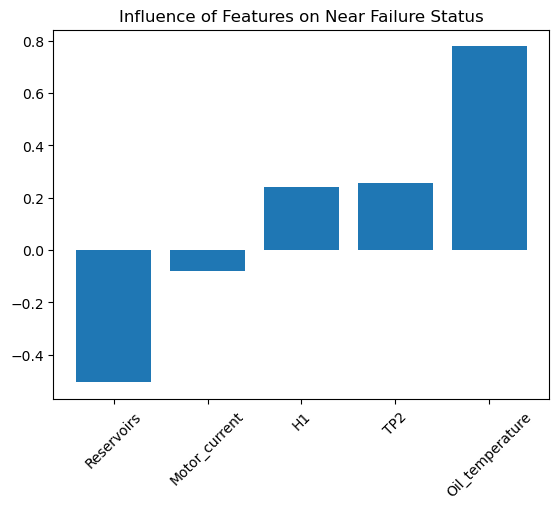

In [44]:
# The very high metrics from evaluating this model may indicate a Logistic Regression model is not the ideal choice.
# Could also indicate data leakage between train/test/highly-correlated features, currently investigating for leakage



logreg_1 = LogisticRegression(random_state=17, class_weight={True:100, False:1})

logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)

feature_importances = pd.DataFrame(data={"Feature": X.columns, "Importance": logreg_1.coef_[0]}).sort_values(by='Importance')

print(y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
plt.bar(feature_importances["Feature"], feature_importances["Importance"])
plt.xticks(rotation=45)
plt.title("Influence of Features on Near Failure Status")
plt.show()

In [45]:
xgb_model = XGBClassifier(objective='binary:logistic', n_estimators=10, seed=17)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99    441564
        True       0.93      0.01      0.03      4535

    accuracy                           0.99    446099
   macro avg       0.96      0.51      0.51    446099
weighted avg       0.99      0.99      0.99    446099



In [46]:
"""params={"objective":"binary:logistic","max_depth":4}

dtrain = DMatrix(X_train, y_train)

cv_results = cv(dtrain=dtrain, params=params, nfold=4, num_boost_round=10, metrics="error", as_pandas=True)

print("Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))"""

'params={"objective":"binary:logistic","max_depth":4}\n\ndtrain = DMatrix(X_train, y_train)\n\ncv_results = cv(dtrain=dtrain, params=params, nfold=4, num_boost_round=10, metrics="error", as_pandas=True)\n\nprint("Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))'

# Feature Extraction

The BAR pressure value in the reservoirs ('Reservoirs') should be close to that measured at the pneumatic panel (TP3).
Next I create a dif_panel_reservoir feature by subtracting the value of 'Reservoirs' from the value of 'TP3' for each record.

In [47]:
# Creating a feature dif_panel_reservoir by subtracting Reservoirs value from TP3 value

metro_df_large['dif_panel_reservoir'] = abs(metro_df_large['TP3'] - metro_df_large['Reservoirs'])

metro_df_large['dif_panel_reservoir'].describe()

count    1.516948e+06
mean     1.862102e-03
std      1.712118e-03
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e-03
75%      2.000000e-03
max      1.820000e-01
Name: dif_panel_reservoir, dtype: float64

Creating a feature for the rolling average of the oil temperature.

In [48]:
metro_df_large['oil_rolling'] = metro_df_large['Oil_temperature'].rolling(6).mean()
metro_df_large.head(20)

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,...,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,dif_panel_reservoir,oil_rolling
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,0,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,NaN
2020-02-01 00:00:10,10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,NaN
2020-02-01 00:00:19,20,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,NaN
2020-02-01 00:00:29,30,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,NaN
2020-02-01 00:00:39,40,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,NaN
2020-02-01 00:00:49,50,-0.012,9.306,9.290,-0.024,9.308,53.500,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,53.545833
2020-02-01 00:00:59,60,-0.012,9.296,9.280,-0.024,9.298,53.375,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,53.508333
2020-02-01 00:01:09,70,-0.014,9.286,9.270,-0.024,9.286,53.550,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,53.487500
2020-02-01 00:01:19,80,-0.012,9.276,9.258,-0.022,9.276,53.425,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,53.458333


In [49]:
"""metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)
metro_df_clustering.info()"""

'metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)\nmetro_df_clustering.info()'

In [50]:
"""# Set up KMeans
kmeans = KMeans(n_clusters=4, n_init=10)

# Fit the model to the data
kmeans.fit(metro_df_clustering)

# Predict the clusters
metro_df_large['cluster'] = kmeans.predict(metro_df_clustering)"""

"# Set up KMeans\nkmeans = KMeans(n_clusters=4, n_init=10)\n\n# Fit the model to the data\nkmeans.fit(metro_df_clustering)\n\n# Predict the clusters\nmetro_df_large['cluster'] = kmeans.predict(metro_df_clustering)"

In [51]:
metro_df_large.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,...,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,dif_panel_reservoir,oil_rolling
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,0,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.0,NaN
2020-02-01 00:00:10,10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.0,NaN
2020-02-01 00:00:19,20,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.0,NaN
2020-02-01 00:00:29,30,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.0,NaN
2020-02-01 00:00:39,40,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.0,NaN


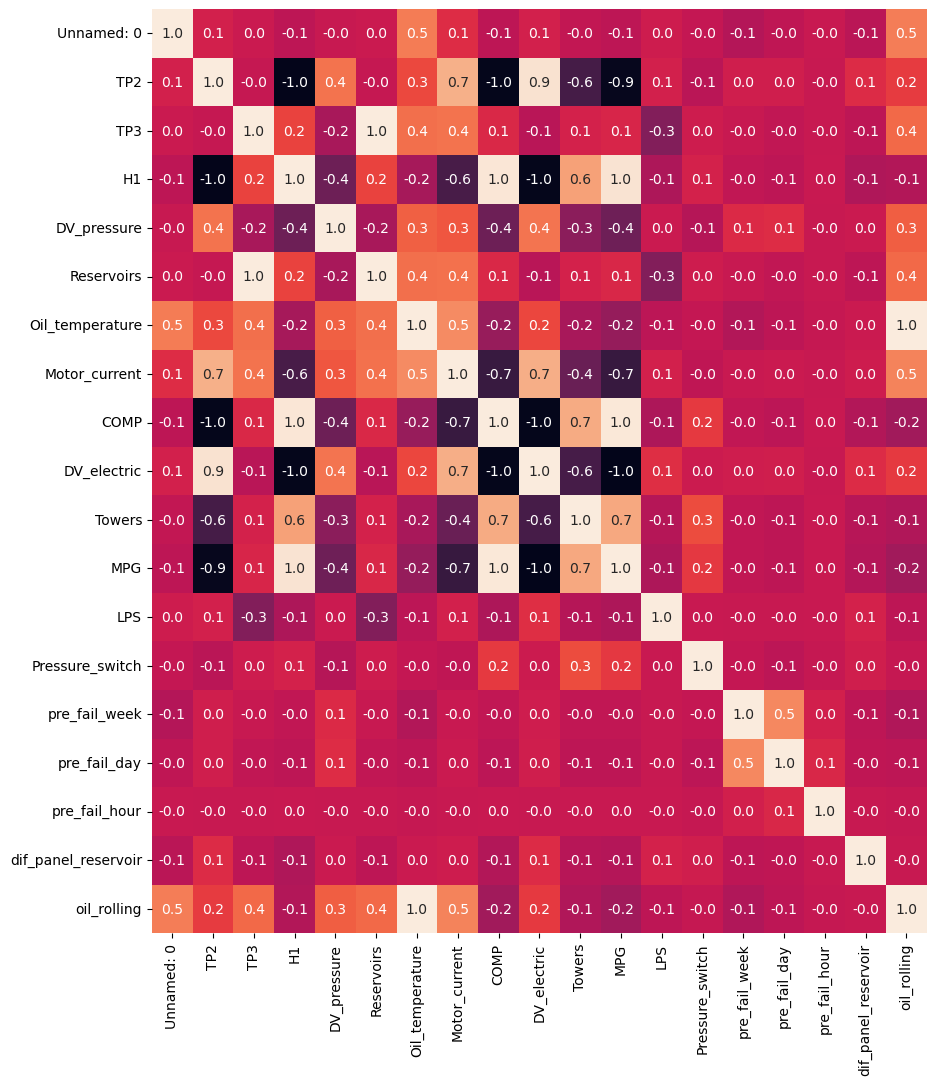

In [52]:
fig = plt.figure(figsize=(10,12))
hm = metro_df_large.drop(columns=['Oil_level','Caudal_impulses'], axis=1).corr(numeric_only=True)
sns.heatmap(hm, annot=True, fmt='.1f', cbar=False)
plt.show()

In [53]:
"""cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()
cluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()
cluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()
cluster_3_df = metro_df_large[metro_df_large.cluster == 3].copy()


cluster_0_df.head()"""


'cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()\ncluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()\ncluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()\ncluster_3_df = metro_df_large[metro_df_large.cluster == 3].copy()\n\n\ncluster_0_df.head()'

In [54]:
#cluster_0_df.describe()

In [55]:
#cluster_1_df.describe()

In [56]:
#cluster_2_df.describe()

In [57]:
# Using the pandas dataframe correlation matrix to create a heatmap of pairwise correlations
"""fig = plt.figure(figsize=(10,12))
hm = cluster_0_df.drop(columns=['Oil_level','Caudal_impulses','LPS'],axis=1).corr(numeric_only=True)
sns.heatmap(hm, annot=True, fmt='.1f', cbar=False)
plt.show()"""

"fig = plt.figure(figsize=(10,12))\nhm = cluster_0_df.drop(columns=['Oil_level','Caudal_impulses','LPS'],axis=1).corr(numeric_only=True)\nsns.heatmap(hm, annot=True, fmt='.1f', cbar=False)\nplt.show()"

Feature extraction:
* rolling averages of features
* frequency of n percentile measurements (high stress / temp / motor current)
* 